## **Recognizing the NAO with K-means clustering**
* The following notebook served as inspiration for some of what I do here (and is a great resource in itself): https://colab.research.google.com/drive/1pkPYYWYrO5q7IT2rNeJyMRkgbAOxKdQS#scrollTo=GuzOihHuXLxu
* As seen elsewhere in this repository, the NAO can be visualized using Principal Component Analysis. See [that notebook](https://github.com/austinbennysmith/ML_EarthScience/blob/main/NAO_example.ipynb) for more information about the NAO as well as a general introduction to some of the modules being used here for accessing the data. This notebook applied another machine learning method, K-means clustering. The pattern appears roughly the same, but you can see that there are a few things that vary substantially, such as the pattern over northeastern Greenland.

In [ ]:
## This was originall a Google Colaboratory notebook that I had to download and convert to Jupyter due to technical issues. To use this in Googe Colab, use the following installation sequence:

# !grep '^deb ' /etc/apt/sources.list | \
#   sed 's/^deb /deb-src /g' | \
#   tee /etc/apt/sources.list.d/deb-src.list
# !apt-get -qq update

# !apt-get -qq build-dep python3-cartopy
# !pip uninstall -y shapely

# !pip install --no-binary cartopy cartopy==0.17.0

# !pip install fsspec

# !apt-get -V -y -qq install python-cartopy python3-cartopy

# !pip uninstall shapely -y

# !pip install shapely --no-binary shapely

# !pip install zarr

# ! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
from nc_time_axis import NetCDFTimeConverter, CalendarDateTime
import cftime
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import pca

In [2]:
## The following imports are just copied from https://colab.research.google.com/drive/1pkPYYWYrO5q7IT2rNeJyMRkgbAOxKdQS#scrollTo=w-gylqlLBn8H
## (I'll consolidate it later)

#General Python math functions
import math

#Loading in data (netcdf files)
import xarray as xr

#Handling data
import numpy as np

#Plotting figures
import matplotlib.pyplot as plt #Main plotting package
from matplotlib import rcParams #For changing text properties
# import cmocean #A package with beautiful colormaps
import cartopy #Useful for plotting maps
import cartopy.util #Requires separate import

#Making neural networks; Ensure we are using tensorflow 1.15
# %tensorflow_version 1.x
# import keras

#Non-neural network machine learning/unsupervised learning algorithms
import sklearn.cluster
import scipy.cluster
import sklearn.decomposition

#Self organizing maps
# from minisom import MiniSom


I use [Pangeo](https://pangeo-data.github.io/pangeo-cmip6-cloud/) to access the climate model data. The files are organized in a csv format:

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv') 
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,6hrPlev,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


Next I choose the Sea Level Pressure variable ('psl') in a 'historical' simulation that simulates the years 1850-2014. The table_id=='Amon' specification asks for monthly data, and I am only looking at data from the CESM2 model. Printing the length of the resulting dataset gives me the number of runs available with these conditions (there are 11). I will look at just one simulation.

In [4]:
psl_historical = df.query("variable_id == 'psl' & experiment_id == 'historical' & table_id == 'Amon' & source_id == 'CESM2'")
print(len(psl_historical))

11


In the following cell I open the actual data. I initially open it as an Xarray Dataset (this is the xr.open_zarr command) and use xarray to slice the dataset so that I have the latitude and longitude range of the NAO (latitude 20-80N, longitude 90W-40E). I also restrict it to only the Winter months (December, January, February). This cell converts the Xarray Dataset to a numpy array, and the rest of the notebook will not use Xarray, but Xarray is worth discussing a bit because of how useful it is for climate applications.

[Xarray](http://xarray.pydata.org/en/stable/) is a package based on Pandas and is very useful for working with climate data stored as NetCDF files. [NetCDF](https://www.unidata.ucar.edu/software/netcdf/?_ga=2.77896087.2016730849.1613498586-174498609.1613498586) (Network Common Data Form) files can efficiently store multidimensional data such as the Sea Level Pressure data considered here (stored in latitude, longitude, and time dimensions). NetCDF files also contain attributes and metadata and are thus self-describing. Working with NetCDF files using Xarray (by reading them using xr.open_dataset or similar functions) makes it very easy to slice the files the way you want and perform a variety of operations on them.

An alternative to Xarray is the NetCDF4 module, though it is less versatile.

In [5]:
# Accessing the file, getting it to just the lats and lons I want:
zstore = psl_historical.zstore.values[0] # By choosing index 0, I am looking at just the first of 11 available simulations meeting my specifications
mapper = fsspec.get_mapper(zstore)
ds = xr.open_zarr(mapper, consolidated=True, decode_times=True) # Opening the file using Xarray
psl = ds.psl.sel(lat=slice(20,80)) # Choosing latitudes 20-80N
psl = psl.where((ds.lon >= 270) | (ds.lon <= 40), drop=True) # Choosing longitudes 90W-40E
lat = ds.lat.sel(lat=slice(20,80)) # Defining a latitude variable
lon = ds.lon.where((ds.lon >= 270) | (ds.lon <= 40), drop=True) # Defining a longitude variable

# The following function tests whether a given data point is in the Winter season:
def is_djf(month): # source: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months
  return (month>=12) | ((month>=1) & (month<=2)) # The | symbol is an OR operator
psl_djf = psl.sel(time=is_djf(psl['time.month'])) # I define a psl_djf Xarray object that applies the is_djf function to the psl Dataset. psl['time.month'] is an Xarray DataArray containing the month values of the time dimension. This is an example of how convenient Xarray is: it's very easy to slice the arrays exactly the way you want.
psl_djf_np = psl_djf.values # Here I convert the Xarray object to a numpy array. psl_djf is an Xarray DataArray, but psl_djf.values is a numpy object

In [6]:
psl_djf_np = psl_djf_np.reshape(len(psl_djf.time), len(psl_djf.lat)*len(psl_djf.lon)) # Reshaping it so that lat and lon are part of the same dimension
kmeans_model = sklearn.cluster.KMeans(n_clusters=2, random_state=10).fit(psl_djf_np) # Feel free to play with the number of clusters
nao_clusters = kmeans_model.fit_predict(psl_djf_np)

In [7]:
cluster0_indices = np.argwhere(nao_clusters == 0)[:,0] # np.argwheree finds which points were assigned to the cluster.
cluster1_indices = np.argwhere(nao_clusters == 1)[:,0]
cluster0_composite = np.mean(psl_djf_np[cluster0_indices], axis=0).reshape(len(psl_djf.lat), len(psl_djf.lon)) # Reshaping to. be a 2d map again with both lat & lon.
cluster1_composite = np.mean(psl_djf_np[cluster1_indices], axis=0).reshape(len(psl_djf.lat), len(psl_djf.lon))

**K-means clustering (2 clusters):**

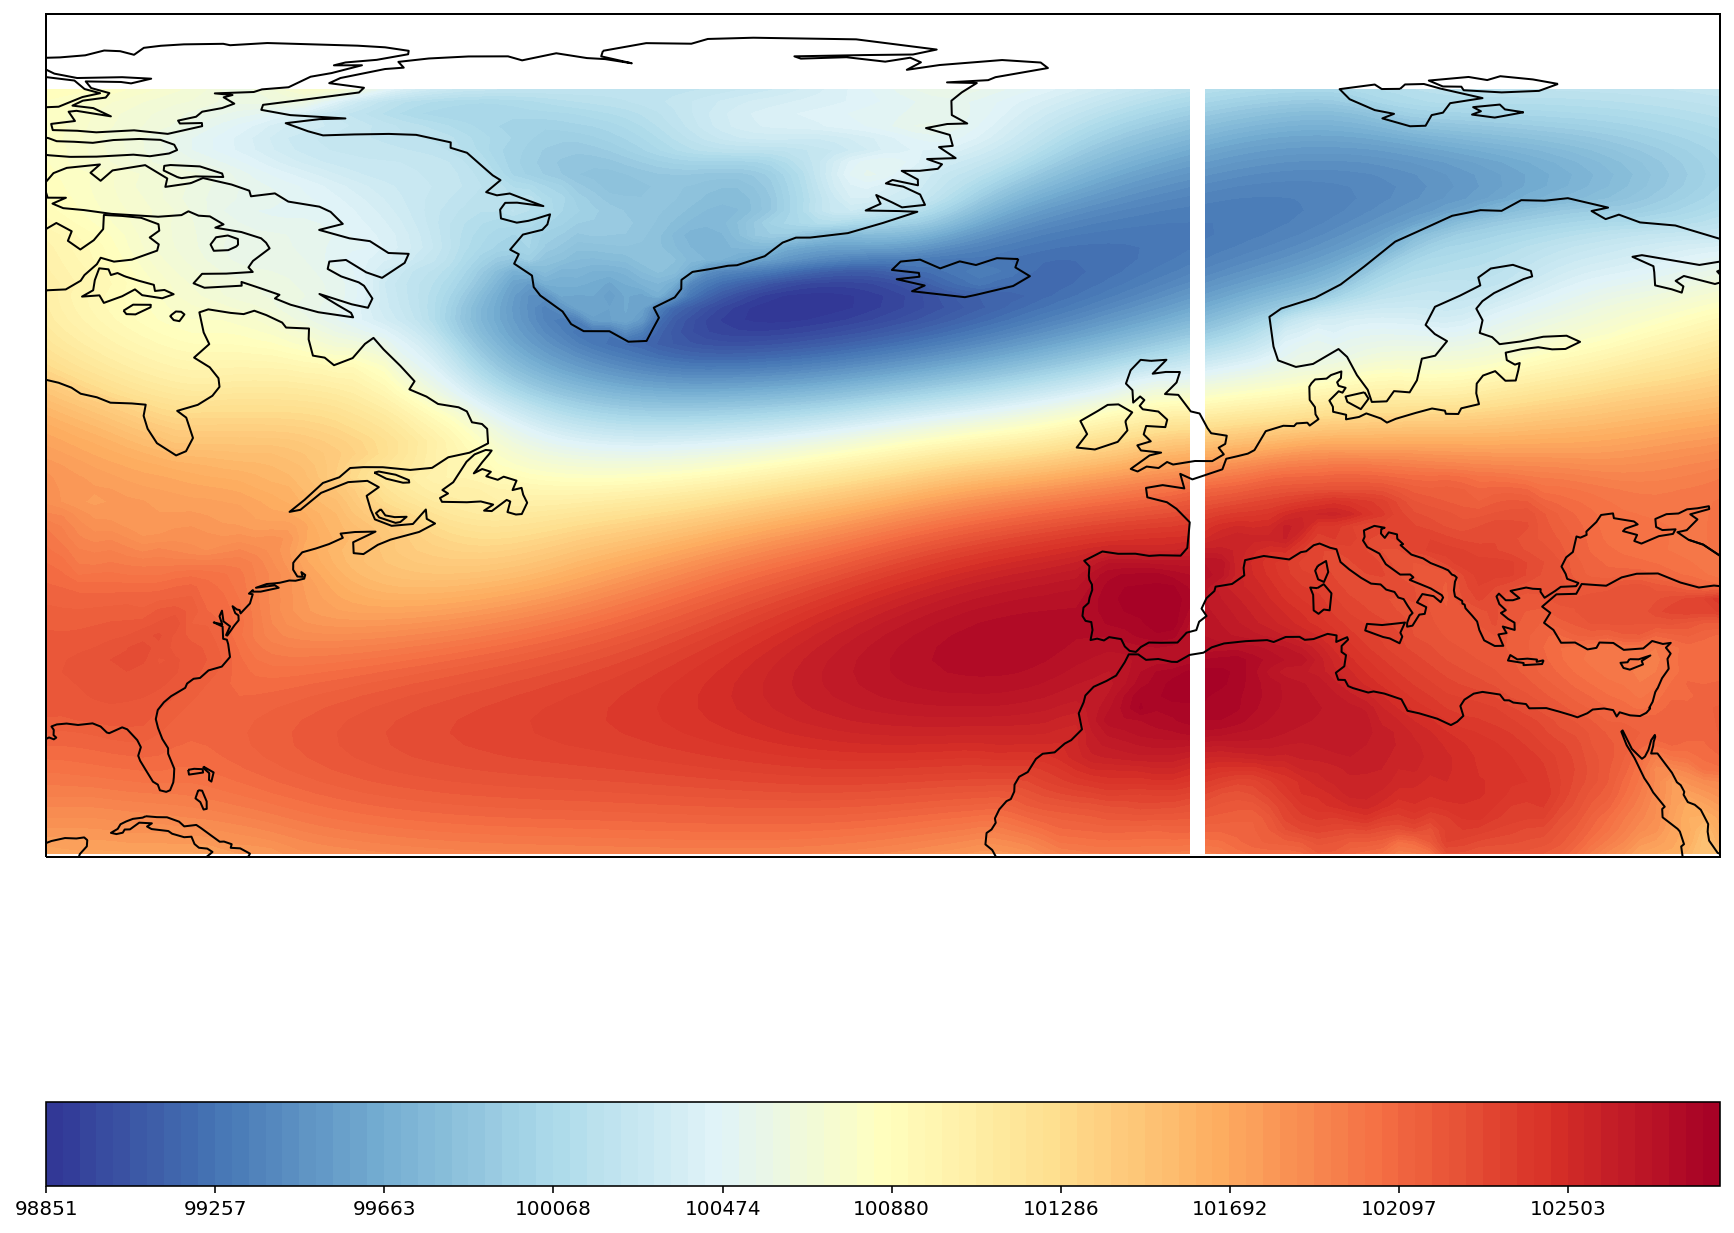

In [10]:
## Making a contour plot:

mins = []
maxes = []
plt.figure(figsize=[15, 15])
for i in cluster0_composite:
  mins.append(min(i))
  maxes.append(max(i))
levels = np.linspace(min(mins), max(maxes), 100)

ax = plt.axes(projection=ccrs.PlateCarree())
cs=ax.contourf(lon, lat, cluster0_composite[:, :],levels,
              transform=ccrs.PlateCarree(),
              cmap=plt.cm.RdYlBu_r)
ax.coastlines()
ax.set_extent([-90, 40, 20, 80]) # longitude latitude extent
plt.colorbar(cs, orientation='horizontal') # color map
plt.show()

**More clusters:**

In [13]:
number_clusters = 4
kmeans_model = sklearn.cluster.KMeans(n_clusters=number_clusters, random_state=10).fit(psl_djf_np)
nao_clusters = kmeans_model.fit_predict(psl_djf_np)
all_clusters = {}
for i in range(number_clusters):
  cluster_indices = np.argwhere(nao_clusters == i)[:,0]
  cluster_composite = np.mean(psl_djf_np[cluster_indices], axis=0).reshape(len(psl_djf.lat), len(psl_djf.lon))
  all_clusters['cluster'+str(i+1)+'_composite'] = cluster_composite

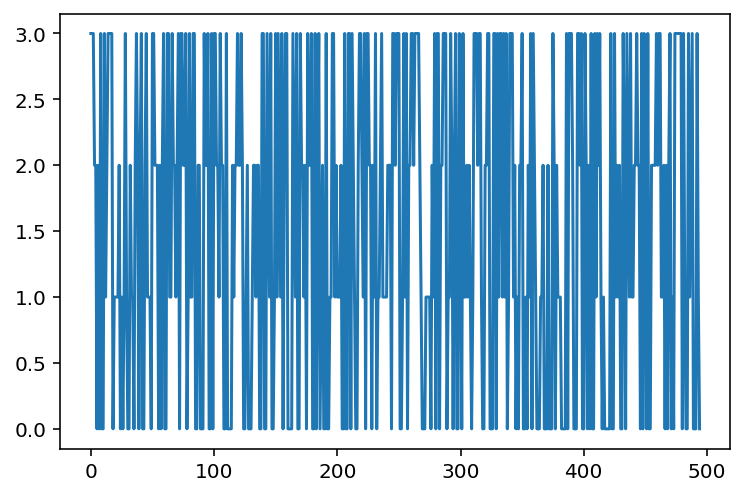

In [ ]:
nao_clusters

Plotting the clusters:

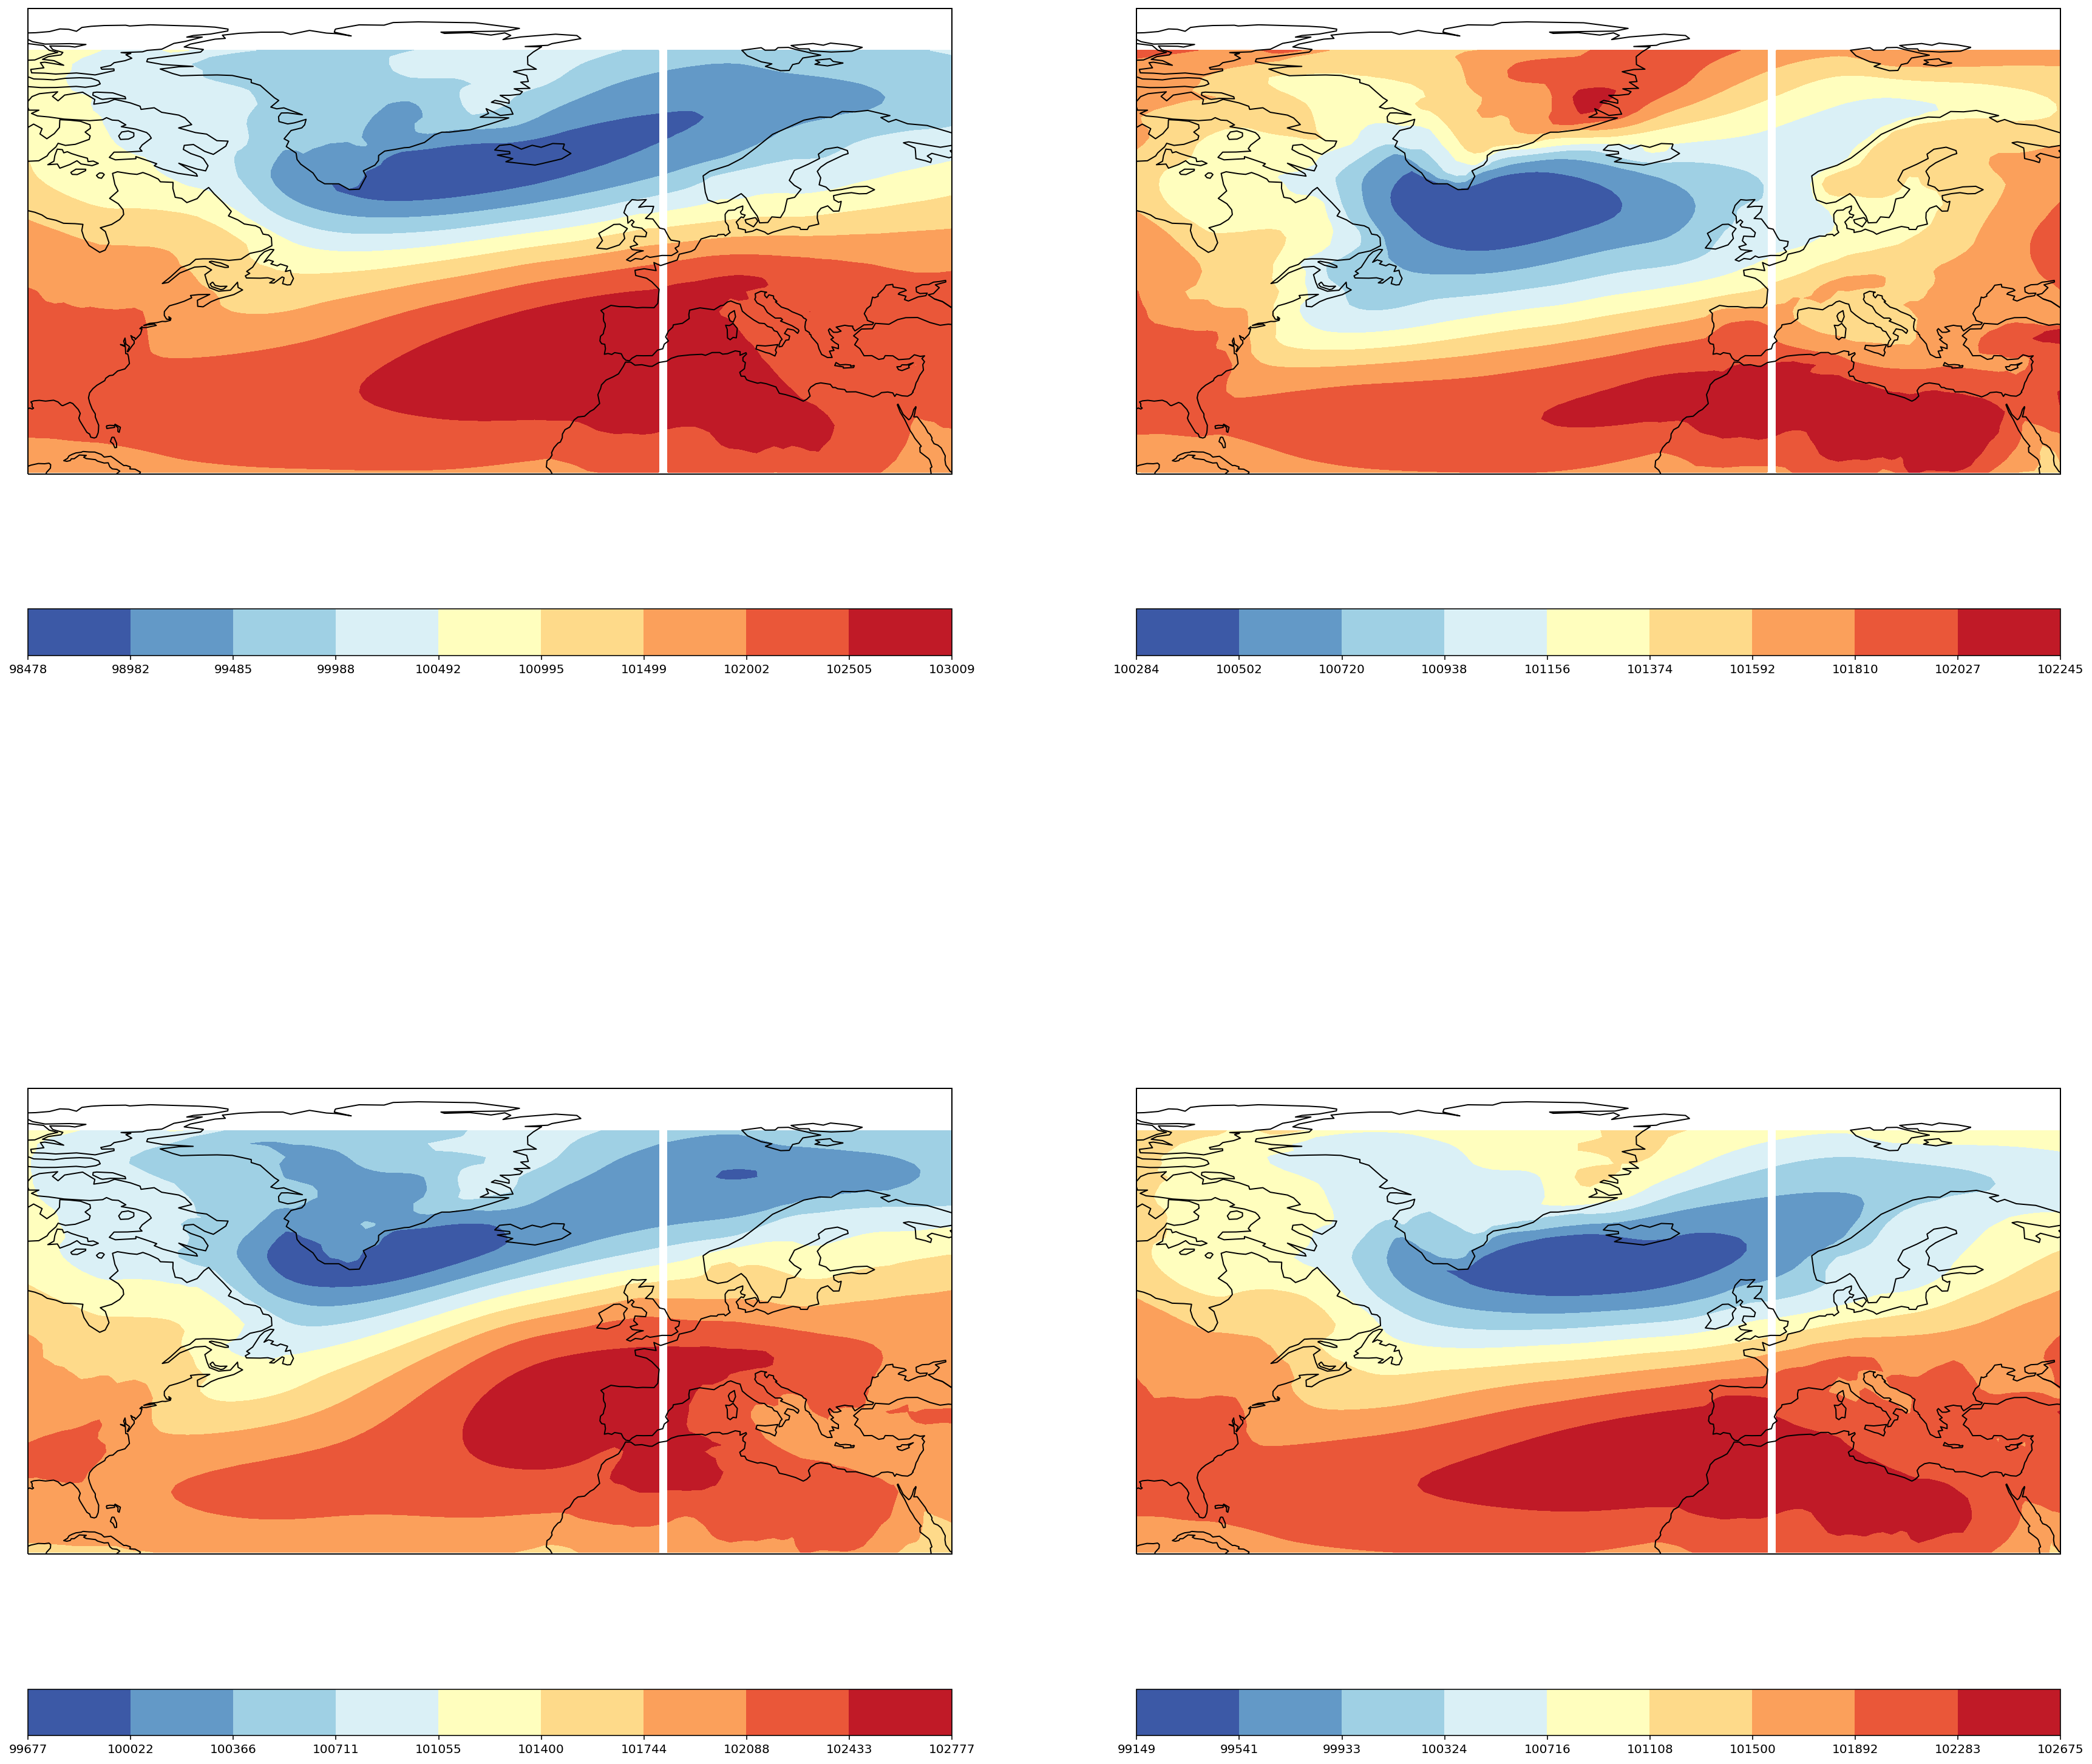

In [18]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(30, 30), subplot_kw={'projection': ccrs.PlateCarree()})
axlist = axarr.flatten()
for i in range(number_clusters):
  mins = []
  maxes = []
  for j in all_clusters['cluster'+str(i+1)+'_composite']:
    mins.append(min(j))
    maxes.append(max(j))
  levels = np.linspace(min(mins), max(maxes), 10)

  # ax = plt.axes(projection=ccrs.PlateCarree())
  cs=axlist[i].contourf(lon, lat, all_clusters['cluster'+str(i+1)+'_composite'][:, :],levels,
                transform=ccrs.PlateCarree(),
                cmap=plt.cm.RdYlBu_r)
  axlist[i].coastlines()
  axlist[i].set_extent([-90, 40, 20, 80]) # longitude latitude extent
  cbar = fig.colorbar(cs, ax=axlist[i], orientation='horizontal')# color map
plt.show()

You may notice that the difference between clusters seems to be fairly small. This is because the NAO has a single dominant pattern, which we can see by simply taking the time average and plotting it:

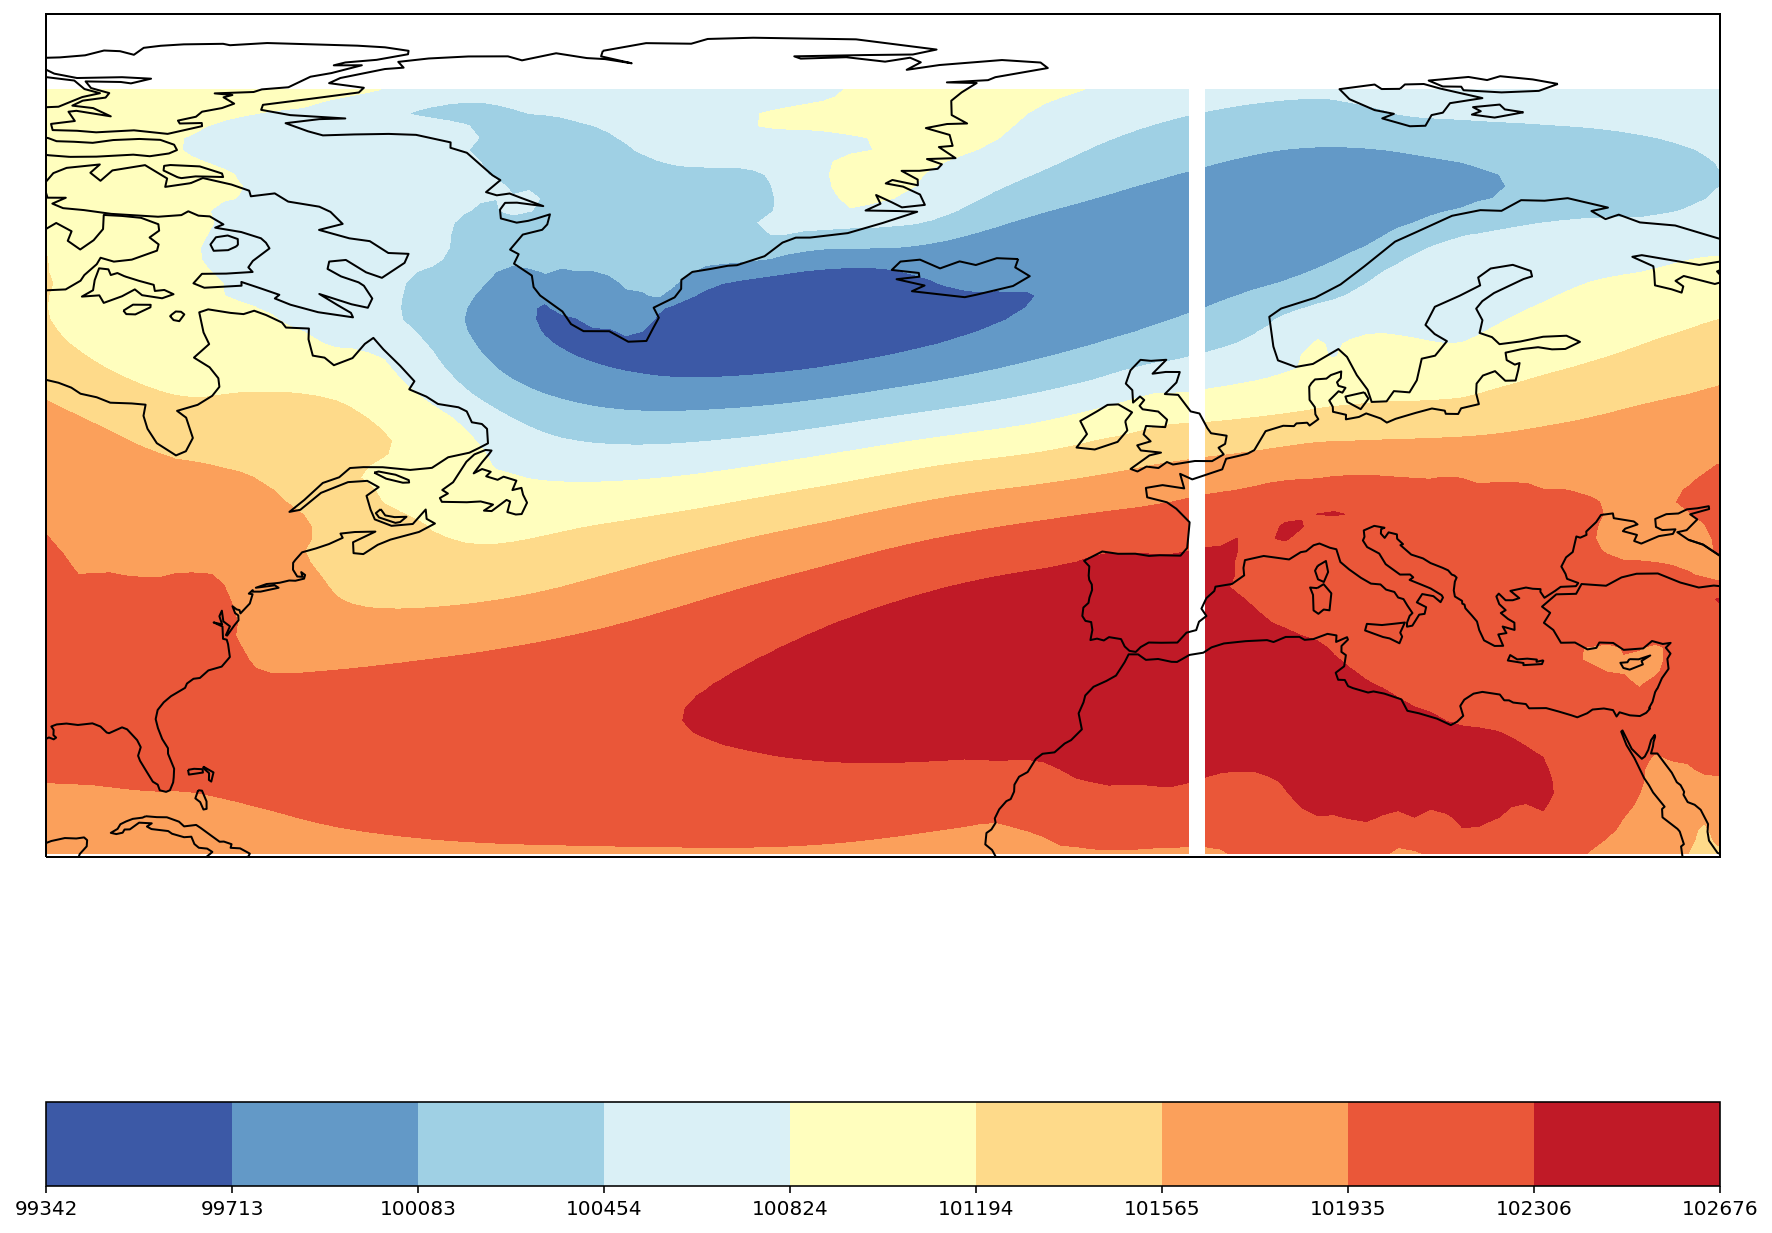

In [22]:
test = np.mean(psl_djf_np, axis=0).reshape(len(psl_djf.lat), len(psl_djf.lon))
mins = []
maxes = []
for j in test:
  mins.append(min(j))
  maxes.append(max(j))
levels = np.linspace(min(mins), max(maxes), 10)

plt.figure(figsize=[15, 15])
ax = plt.axes(projection=ccrs.PlateCarree())
cs=ax.contourf(lon, lat, test[:, :],levels,
              transform=ccrs.PlateCarree(),
              cmap=plt.cm.RdYlBu_r)
ax.coastlines()
ax.set_extent([-90, 40, 20, 80]) # longitude latitude extent
plt.colorbar(cs, orientation='horizontal') # color map
plt.show()

To see which cluster different time slices are in, we can print the nao_clusters array:

In [29]:
nao_clusters

array([3, 3, 3, 2, 2, 0, 2, 0, 3, 0, 0, 3, 1, 2, 3, 3, 3, 3, 0, 1, 1, 1,
       1, 2, 0, 1, 0, 1, 3, 1, 0, 0, 2, 1, 1, 0, 2, 3, 2, 0, 2, 3, 0, 0,
       2, 3, 1, 1, 1, 0, 3, 3, 2, 2, 2, 0, 2, 0, 2, 3, 0, 0, 3, 3, 1, 1,
       3, 2, 2, 1, 2, 3, 0, 3, 3, 2, 2, 3, 0, 1, 3, 1, 1, 3, 3, 0, 0, 2,
       2, 0, 0, 0, 3, 2, 2, 3, 0, 0, 3, 0, 3, 3, 2, 2, 1, 3, 2, 2, 0, 0,
       3, 0, 0, 0, 0, 2, 1, 2, 2, 3, 2, 2, 3, 2, 0, 0, 1, 2, 0, 0, 0, 1,
       2, 2, 1, 2, 2, 0, 0, 3, 3, 0, 0, 3, 2, 1, 3, 0, 0, 1, 3, 1, 3, 2,
       1, 3, 0, 2, 3, 3, 0, 0, 0, 0, 3, 2, 1, 3, 0, 0, 3, 2, 2, 1, 2, 0,
       3, 2, 2, 3, 0, 0, 3, 0, 2, 3, 0, 1, 2, 0, 0, 3, 0, 0, 1, 1, 3, 3,
       1, 2, 1, 1, 1, 2, 0, 0, 3, 0, 0, 3, 3, 0, 3, 2, 1, 0, 0, 2, 3, 3,
       2, 1, 3, 0, 3, 3, 2, 2, 0, 2, 1, 3, 0, 1, 1, 2, 3, 1, 1, 1, 1, 2,
       2, 2, 0, 3, 3, 2, 3, 3, 3, 0, 0, 1, 3, 1, 3, 0, 2, 2, 3, 3, 2, 3,
       3, 3, 3, 2, 1, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 3, 0, 3, 3, 0, 2, 2,
       3, 3, 3, 0, 1, 1, 3, 2, 0, 2, 3, 0, 0, 3, 2,